In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np


In [2]:
# dataset = pd.read_pickle('../../geodata/results/01_master_building_dataset.pkl')
dataset = pd.read_pickle('../../../geodata/results/01_master_building_dataset.pkl')

maxvsh_cols    = dataset.columns[dataset.columns.str.contains('maxvsh')].tolist()
vaccess_cols   = dataset.columns[dataset.columns.str.contains('vwa')].tolist()
# mean_cols      = dataset.columns[dataset.columns.str.contains('mn')].tolist()
dist_cols      = dataset.columns[dataset.columns.str.contains('sum_')].tolist()
vconfig_cols   = np.setdiff1d(dataset.columns[np.where(dataset.columns == 'snt_0')[0][0]:np.where(dataset.columns == 'cmpx_gini')[0][0]+1].tolist(),dist_cols).tolist()
id_cols        = ['ID_Geb','Stockwerk','FassPktX','FassPktY','FassPktZ']

dataset['unit_pano'] = dataset['unit_pano'].fillna(0)



In [3]:
import joblib
# xgb_model   = joblib.load("../../geodata/results/t10agglo_models/tr292ts73_XGB.joblib")
xgb_model   = joblib.load("../../../geodata/results/t10agglo_models/tr292ts73_XGB.joblib")
model_feats    = maxvsh_cols+vaccess_cols+vconfig_cols+dist_cols

# scaler_4model   = joblib.load("../../geodata/results/scaler_for_model.joblib")
scaler_4model   = joblib.load("../../../geodata/results/scaler_for_model.joblib")

X = dataset.copy()
X[model_feats] = scaler_4model.transform(dataset[model_feats])

X['XGB'] = xgb_model.predict(X[xgb_model.feature_names_in_])
X = X.reset_index()


[14:16:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



/Users/adamswietek/opt/anaconda3/envs/env_intel_sdb/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Axes: >

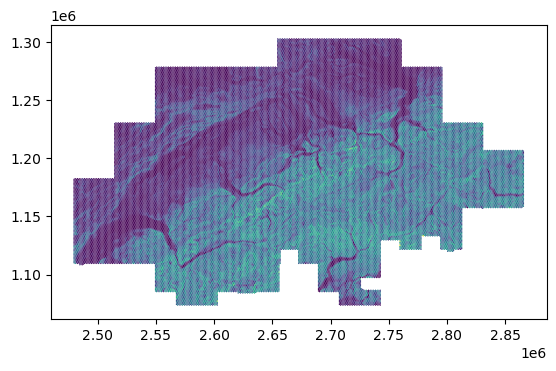

In [4]:
# ch_hexbin = gpd.read_file('../../geodata/ch_terrain/ch_slope_2056.gpkg').reset_index()
ch_hexbin = gpd.read_file('../../../geodata/ch_terrain/ch_slope_2056.gpkg').reset_index()
ch_hexbin.rename(columns = {'index':'hexbin_id','_median':'slope_median', '_mean':'slope_mean'}, inplace = True)
ch_hexbin.plot('slope_mean', edgecolor = 'none')

In [5]:
%time X = gpd.sjoin(ch_hexbin[['hexbin_id', 'slope_mean','slope_median','geometry']],X,how='right')

CPU times: user 10.7 s, sys: 13.6 s, total: 24.2 s
Wall time: 29.4 s


In [6]:
#get average neighbor value
%time buffered = X.buffer(100, cap_style=3)
%time buff_idx, pt_idx = X.geometry.sindex.query_bulk(buffered, predicate="contains")
%time latent = np.take(X[['slope_median','slope_mean','XGB']], pt_idx, axis=0)
%time group = pd.DataFrame(latent).groupby(buff_idx)
%time nabr = group.mean()
X['nabr_avg_slope'] = nabr.slope_mean
X['nabr_med_slope'] = nabr.slope_median
X['nabr_avg_pred']  = nabr.XGB
X['nabr_count']     = group.size()

CPU times: user 36 s, sys: 798 ms, total: 36.8 s
Wall time: 36.9 s
CPU times: user 1min 23s, sys: 2.32 s, total: 1min 25s
Wall time: 1min 26s
CPU times: user 4.42 s, sys: 1.03 s, total: 5.45 s
Wall time: 5.5 s
CPU times: user 313 µs, sys: 396 µs, total: 709 µs
Wall time: 706 µs
CPU times: user 3.36 s, sys: 2.03 s, total: 5.39 s
Wall time: 6.67 s


In [7]:
X.to_pickle('../../../geodata/results/02_spatial_lagged_master.pkl')
# X = pd.read_pickle('../../geodata/results/02_spatial_lagged_master.pkl')

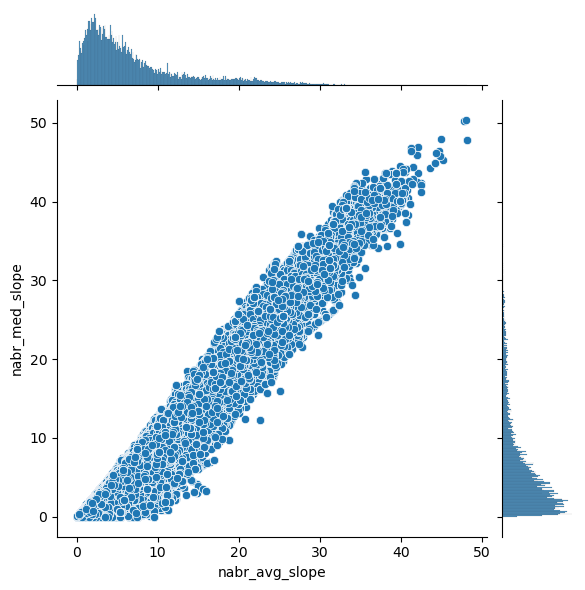

In [8]:
import seaborn as sns

sns.jointplot(x='nabr_avg_slope', y='nabr_med_slope', data=X)